In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
from tools import _init_paths
from pathlib import Path
import torch
import torchvision.transforms as transforms
import numpy as np
import pylab
pylab.rcParams['figure.figsize'] = 10.0, 8.0

import dataset
import models
from config import cfg as conf
from config import update_config
from utils.utils import model_key_helper
from core.inference import get_final_preds_match


class Visualizer:
    SKEL = [[16, 14], [14, 12], [17, 15], [15, 13], [12, 13], [6, 12], [7, 13], 
            [6, 7], [6, 8], [7, 9], [8, 10], [9, 11], [2, 3], [1, 2], [1, 3], 
            [2, 4], [3, 5], [4, 6], [5, 7]]

    def plot_results(self, img, pred, vis, scale):
        plt.figure()
        plt.imshow(img)
        ax = plt.gca()
        
        GREEN = [(5,6),(6,8),(8,10)]
        YELLOW = [(5,7),(7,9)]
        BLUE = [(5,11),(11,13),(13,15)]
        PINK = [(6,12),(12,14),(14,16)]

        vis_head = pred[:5][vis[:5] > 0]
        vis_body = pred[5:][vis[5:] > 0]

        for i, j in self.SKEL:
            ki = min(i, j) - 1
            kj = max(i, j) - 1
            # 0-4 head
            # 5,7,9,11,13,15 left
            # 6,8,10,12,14,16 right

            i, j = i - 1, j - 1
            src = pred[i]
            dst = pred[j]
            if vis[i] <= 0 or vis[j] <= 0:
                continue
            if ki < 5 and kj < 5:
                plt.plot([src[0], dst[0]],[src[1], dst[1]], linewidth=1, color=[250/255, 32/255, 98/255, 1], 
                         solid_capstyle='round', zorder=1)
            if ki >=5 and kj >= 5:
                pair = ki, kj
                trans = 1
                if pair in GREEN:
                    color = (38 / 255, 252 / 255, 145 / 255, trans)
                elif pair in YELLOW:
                    color = [250 / 255, 244 / 255, 60 / 255, trans]
                elif pair in BLUE:
                    color = [104 / 255, 252 / 255, 252 / 255, trans]
                elif pair in PINK:
                    color = [255 / 255, 148 / 255, 212 / 255, trans]
                else:
                    continue
                plt.plot([src[0], dst[0]],[src[1], dst[1]], linewidth=6.0 * scale, color=color, 
                         solid_capstyle='round', zorder=1)

            for pnt in vis_head:
                circle = plt.Circle((pnt[0], pnt[1]), 1.5 * scale * 1.2, fill=False, color='black', zorder=10)
                ax.add_artist(circle)
            for pnt in vis_body:
                circle = plt.Circle((pnt[0], pnt[1]), 3.0 * scale * 1.2, fill=False, color='black', zorder=10)
                ax.add_artist(circle)

            
        plt.axis('off')
        plt.show()

class Args:
    cfg = 'experiments/coco/transformer/w32_384x288_adamw_lr1e-4.yaml'
    opts = []
    modelDir = None
    logDir = None
    dataDir = None
    pretrained = 'models/pytorch/pose_coco/pose_transformer_hrnet_w32_384x288.pth'

def inference(config, flip_pairs, input, target, target_weight, meta, transform):
    c = meta['center']
    s = meta['scale']
    outputs = model(transform(input)[None, ...])
    preds, _, preds_raw = get_final_preds_match(config, outputs, c, s)
    input_flipped = np.flip(input, 1).copy()
    outputs_flipped = model(transform(input_flipped)[None, ...])
    preds_flipped, _, preds_raw_flipped = get_final_preds_match(config, outputs_flipped, c, s, flip_pairs)
    preds_raw = (preds_raw + preds_raw_flipped) / 2
    
    vis = meta['joints_vis'][..., 0]
    return preds_raw[0], vis, np.linalg.norm(meta['scale']) / 2

In [2]:
args = Args()
update_config(conf, args)
model = models.pose_transformer.get_pose_net(conf, is_train=False)
model.load_state_dict(model_key_helper(torch.load(args.pretrained, map_location='cpu')))

normalize = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

valid_dataset = dataset.coco(
    conf, conf.DATASET.ROOT, conf.DATASET.TEST_SET, False
)

print(f"Loaded {len(valid_dataset)} images")

loading annotations into memory...
Done (t=0.35s)
creating index...
index created!
Loaded 6352 images


In [3]:
VIS_INDICES = [0, 5, 10, 20, 100, 333]

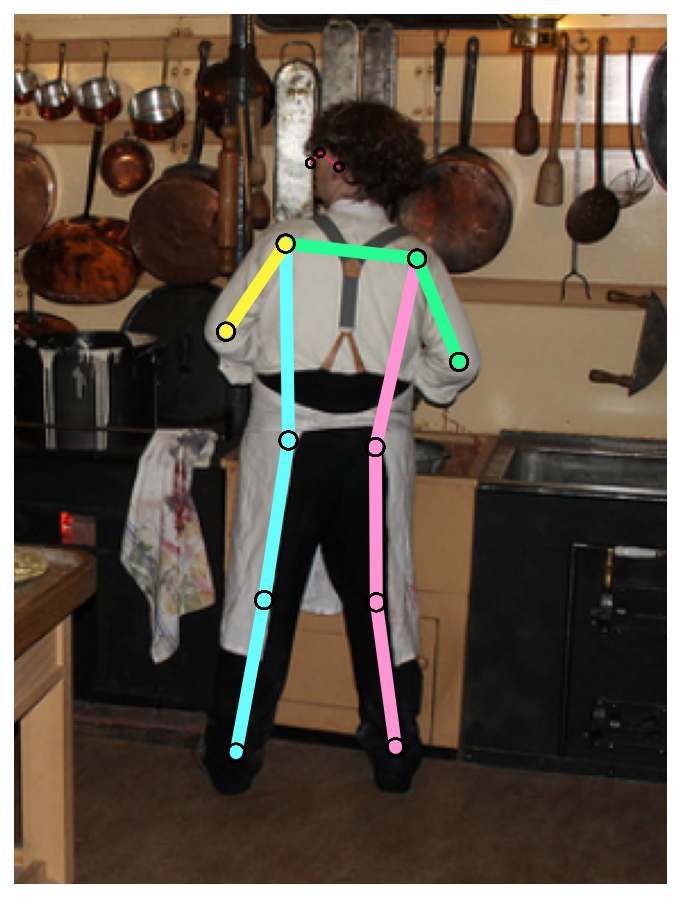

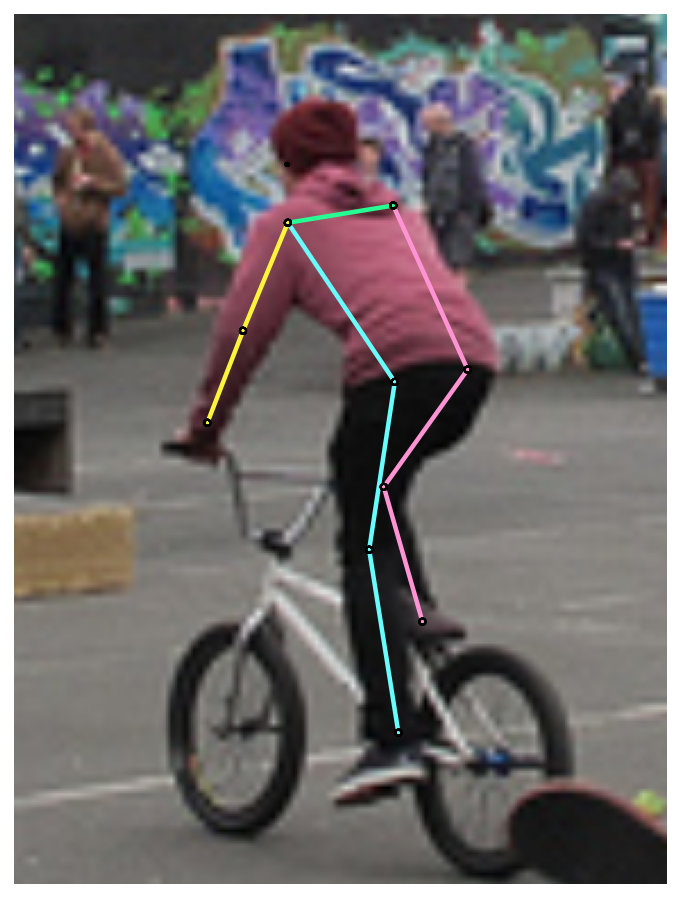

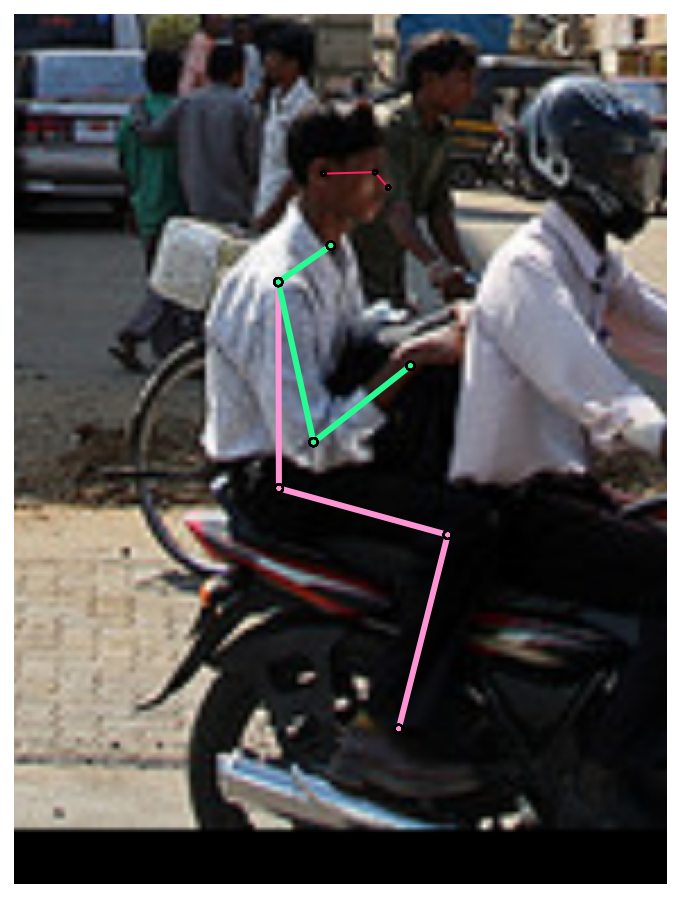

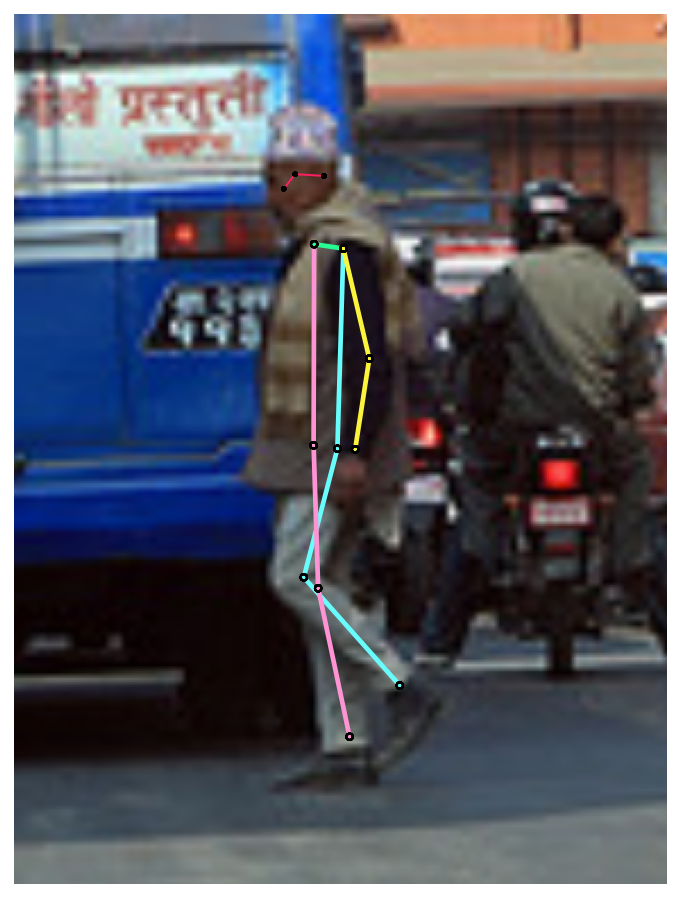

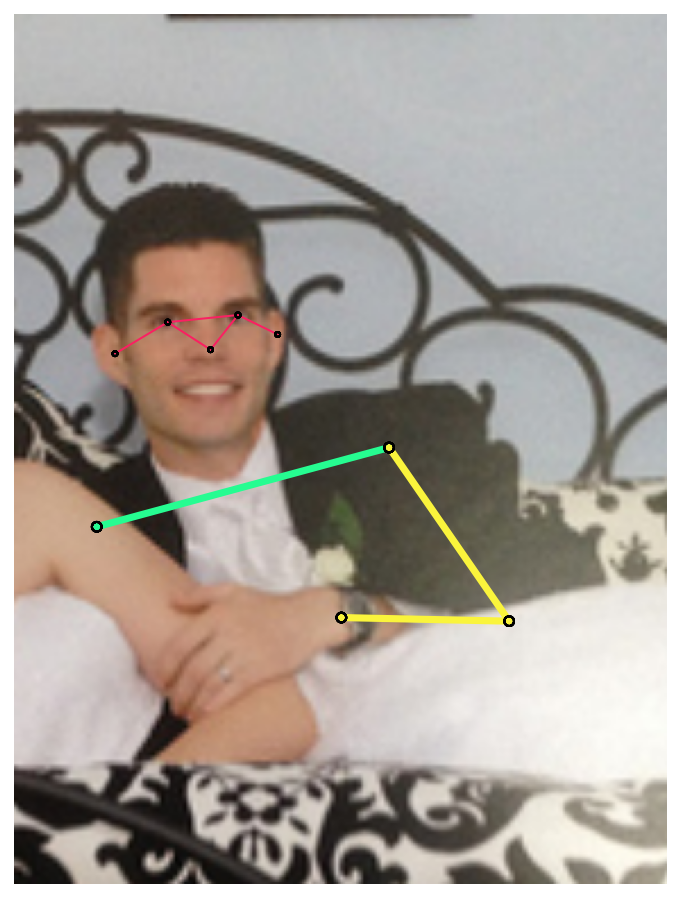

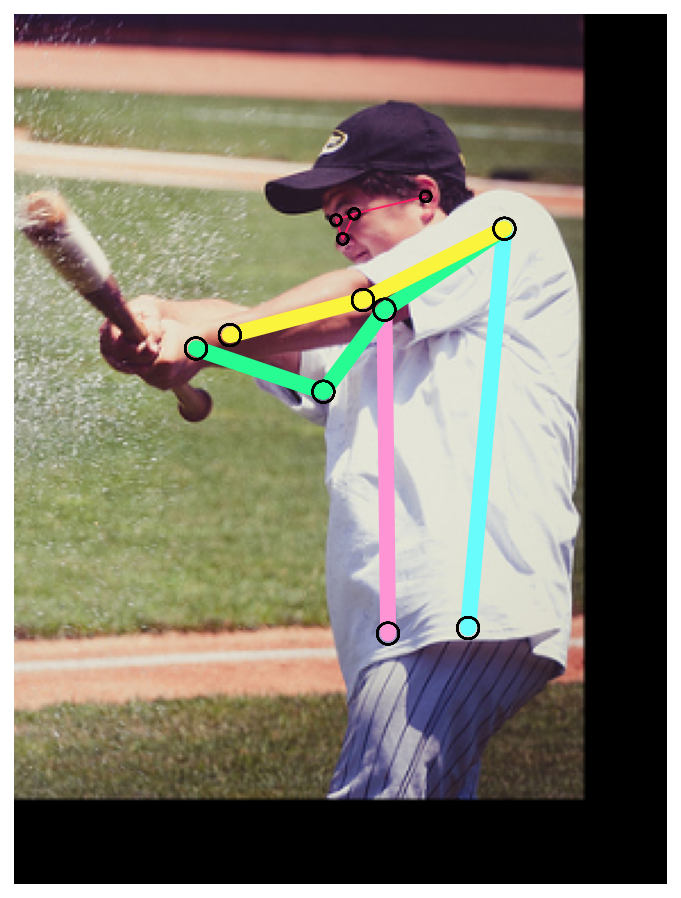

In [4]:
for idx in VIS_INDICES:
    input, target, target_weight, meta = valid_dataset[idx]
    preds_raw, vis, scale = inference(conf, valid_dataset.flip_pairs, input, target, target_weight, meta, transform=normalize)
    Visualizer().plot_results(input, preds_raw, vis, scale)